# Data Preprocessing

Set the environment and variables

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from datetime import timedelta
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

import random
import typing
from collections import Counter
from pathlib import Path

from torch.utils.data import Dataset
from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer

import itertools
from torch import nn
import torch.nn.functional as f


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [35]:
root_addr = "/nfs/home/aliami/mimic4_dataset/physionet.org/files/mimiciv/2.2/hosp/pre_proc_data/"


In [3]:
#read the train and test indexes if they are exist otherwise 
import pickle
with open (root_addr+'saved_idx/mimic4_icd9_val_3spilit', 'rb') as fp:
    X_train_idx = pickle.load(fp)
    
with open (root_addr+'saved_idx/mimic4_icd9_X_test_3spilit', 'rb') as fp:
    X_test_idx = pickle.load(fp)

In [4]:
#read the unique diags and medications 
uniq_diags = np.load(root_addr+'mimic4_uniq_icd9.npy',allow_pickle='TRUE').tolist()
uniq_meds = np.load(root_addr+'mimic4_uniq_atc5.npy',allow_pickle='TRUE').tolist()
len(uniq_diags), len(uniq_meds), uniq_diags[:5], uniq_meds[:5]

(9072,
 773,
 ['5723', '78959', '5715', '07070', '496'],
 ['N02BE01', 'C03CA01', 'J05AX08', 'S01XA14', 'R03CC02'])

Map the Patient trajectories to text format:

    medical code -> token
    new visit -> dot
    visit -> sentence
    patient trajectory -> document
    
output e.g.

    m_N02B d_6103 m_A10A . m_A06A d_3485 m_A04 . m_N02A m_V04C
    
For the interpreteability purposes we added d_ before ICD9 codes and m_ before ATC5 codes 


In [5]:
num_visits= 40
num_visits_test = num_visits

In [6]:
##load data

# Load dictionary
pat_id_visist_dict = np.load(root_addr+'mimic4_all_pat_icd9_atc5.npy',allow_pickle='TRUE').item()

#len(pat_id_visist_dict.keys())

def get_selected_ind_dict(inp_dict, indxs):
    inp_dict = pd.Series(inp_dict) 
    out_dict = {}
    for i in indxs:
        out_dict[inp_dict.index[i]]= inp_dict.iloc[i]
    return out_dict

print(len(pat_id_visist_dict.keys()))
pat_id_visist_dict = get_selected_ind_dict(pat_id_visist_dict, X_train_idx)
print(len(pat_id_visist_dict.keys()))

def make_historical_dataframe(patient_diagnosis_dict, num_visit_per_patient=10, target_icd9_code= "428", zero_padding=False): #428
  
  data_disease_df_list = []
  dtarget = "1"
  for key, val in tqdm(patient_diagnosis_dict.items()):
    #reverse the order of visit to have them to have past:furure order
    #because in our preprocessing we put the last visit at the first element of the list
    #val = list(reversed(val))
    #truncate to first 4 digits
    visits_seq = []
    for vis in val:
        #visits_seq.append([code[:4] for code in vis])
        visits_seq.append(["d_"+code[:4] if code in uniq_diags else "m_"+code[:4] for code in vis])
    val = visits_seq
    patient_diagnosis_dict[key] = visits_seq
    if len(val) >= num_visit_per_patient:
        data_disease_df_list.append([*val[-num_visit_per_patient:], dtarget, key])
    else:
        if zero_padding:
            num_of_zero_cols = -(len(val) - num_visit_per_patient)
            temp_list = [["empty"] for i in range(num_of_zero_cols)]
            data_disease_df_list.append([*temp_list,*val, dtarget, key])
            
  col_names = ["visit"+str(i) for i in range(1,num_visit_per_patient+1)] + ["target"] + ["patient_id"]
  data_disease_df = pd.DataFrame(data_disease_df_list, columns=col_names)
  return data_disease_df, patient_diagnosis_dict


def early_normal_death_labeling(disease_target_df):
    list_of_unknown_target = []
    pat_id_visist_dict = np.load('../../pat_id_death_label_dict.pkl',allow_pickle='TRUE')
    for ind,row in disease_target_df.iterrows():
        if row.patient_id in pat_id_visist_dict.keys():
            disease_target_df.at[ind, 'target'] = pat_id_visist_dict[row.patient_id]
        else:
            list_of_unknown_target.append(ind)
    print("numebr of unknown target rows = ", len(list_of_unknown_target))
    return disease_target_df.drop(index=list_of_unknown_target)




def add_special_chars(in_row):
    CLS = '[CLS]'
    PAD = '[PAD]'
    SEP = '[sep]'
    MASK = '[MASK]'
    UNK = '[UNK]'
    return CLS + in_row.replace(".", SEP)


#convert sequence of visits to sequences of sentences
#word=code, visit=sentence
def visit_sec_to_sen_seq(vis_seq_df, number_of_visits=10, add_spec_char=False, duplicate_allowed=True):
    vis_seq_df = (vis_seq_df.iloc[:,0:number_of_visits])
    vis_seq_str_list = []
    for index, row in vis_seq_df.iterrows():
        #delete empty visits
        if not duplicate_allowed:
            row = pd.Series([list(set(visit)) for visit in row])
        #delete empty visits
        row = list(filter(lambda a: a != ["empty"], row.tolist()))
        seq_sen = " . ".join([" ".join(vis) for vis in row])
        if add_spec_char:
            seq_sen = add_special_chars(seq_sen)
            print(seq_sen)
        vis_seq_str_list.append(seq_sen)
    return vis_seq_str_list#pd.DataFrame(vis_seq_str_list).astype(str)


172980
36325


In [7]:
data_disease_df, pat_id_visist_dict = make_historical_dataframe(pat_id_visist_dict,
                                                               num_visit_per_patient=num_visits,
                                                                zero_padding=True)
data_disease_df

vis_seq_df_str = visit_sec_to_sen_seq(data_disease_df, number_of_visits=num_visits,  duplicate_allowed=False)


100%|████████████████████████████████████| 36325/36325 [02:31<00:00, 240.40it/s]


In [11]:
#load the peprocessed data
#vis_seq_df_str = np.load(root_addr+'mimic4eval_vis_seq_df_str_mde_diag.npy',allow_pickle='TRUE').tolist()
#data_disease_df = pd.read_pickle(root_addr+"mimic4eval_data_disease_df_med_diag")

# Predict Heat Failure on the next visit

In [8]:
#delete related medicines to the HF

target_codes_med = ["C09A", "C09B", "C09C", "C09D", 
                   "C03D", "C03C",
                   "A10B"
                   ]
target_codes_med = ["m_"+code for code in target_codes_med]

#delete related medical codes to HF diagnoses
data_disease_df.iloc[:,:num_visits+1] = data_disease_df.iloc[:,:num_visits+1].applymap(lambda cell: [x for x in cell if x not in target_codes_med])

In [9]:
#HF codes in ICD9
target_codes= ["4020", "4021", "4029",
                   "4254",
                   "4250",
                   "4253",
                   "4254",
                   "4259",
                   "4252","4254",
                   "4254", "4259",
                   "4281", 
                   "4280", "4282", "4283", "4284", "4289"
                   ]
target_codes = ["d_"+code for code in target_codes]

In [10]:
def normal_pat_traj_len(input_visits_temp,target_labels_temp, opt_traj_len):
    print(opt_traj_len)
    if not opt_traj_len:
        len_neg_tarj = []
        for ind, lab in enumerate(target_labels_temp):
            if lab ==1:
                len_neg_tarj.append(input_visits_temp[ind].count(['empty']))
        mean_neg_len = len(input_visits_temp[0]) - round(np.mean(len_neg_tarj))
    else:
        mean_neg_len = opt_traj_len
        
    trimmed_traj = []
    for traj in input_visits_temp:
        trimmed_traj.append(traj[-mean_neg_len:])
    
    return trimmed_traj,mean_neg_len


def vis_traj_with_target_labels(data_disease_df,num_visits_inp, opt_traj_len = False):
    target_labels = []
    input_visits = []
    num_visit_per_patient = num_visits_inp
    zero_padding = True

    for pat_index, pat_traj in data_disease_df.iloc[:,:num_visit_per_patient].iterrows():
        #delete trajectories with less than 10 visits
        #print(list(pat_traj))
        prim_num_visits = len(list(pat_traj)) - (list(pat_traj).count(['empty']))
        if prim_num_visits < 10 :
            continue
        for vis_num,vis in enumerate(pat_traj):
            if bool(set(target_codes) & set(vis)):#target_code in vis:
                if vis_num==0 or "empty" in pat_traj[vis_num-1]:
                    break
                else:
                    target_labels.append(1)
                    #delete empty visits
                    inp_traj = [x for x in pat_traj[:vis_num] if x != ["empty"]]
                    if zero_padding:
                        num_of_zero_cols = -(len(inp_traj) - num_visit_per_patient)
                        temp_list = [["empty"] for i in range(num_of_zero_cols)]
                        input_visits.append([*temp_list,*inp_traj])
                    else:
                        input_visits.append(inp_traj)
                
                    break
            if vis_num==len(pat_traj)-1:
                target_labels.append(0)
                #delete empty visits
                inp_traj = [x for x in pat_traj[:vis_num+1] if x != ["empty"]]
                #changed the above line to the following line, to have same length of visits for both pos and neg labels
                #inp_traj = [x for x in pat_traj[:vis_num] if x != ["empty"]]
                if zero_padding:
                    num_of_zero_cols = -(len(inp_traj) - num_visit_per_patient)
                    temp_list = [["empty"] for i in range(num_of_zero_cols)]
                    input_visits.append([*temp_list,*inp_traj])
                else:
                    input_visits.append(inp_traj)
     
    print(np.unique(target_labels, return_counts=True))
    input_visits,mean_neg_len = normal_pat_traj_len(input_visits,target_labels, opt_traj_len)
    #mean_neg_len= 40
    print(np.unique(target_labels, return_counts=True))
    
    return input_visits,target_labels,mean_neg_len



num_visits = 40
    
input_visits, target_labels, mean_neg_len =  vis_traj_with_target_labels(data_disease_df,num_visits, opt_traj_len = False)
        
num_visits = mean_neg_len    


(array([0, 1]), array([641, 243]))
False
(array([0, 1]), array([641, 243]))


In [11]:
#load data folds after deviding withKfold
import pickle

fold_num = 0

with open (root_addr+'saved_idx/mimic4_down_stream_train_5fold_diag_med'+str(fold_num), 'rb') as fp:
    X_train_idx = pickle.load(fp)
    
with open (root_addr+'saved_idx/mimic4_down_stream_val_5fold_diag_med'+str(fold_num), 'rb') as fp:
    X_val_idx = pickle.load(fp)
    
len(X_train_idx),len(X_val_idx),len(X_test_idx)

(11609, 2903, 15569)

# Load the transformer

In [15]:


class JointEmbedding(nn.Module):

    def __init__(self, vocab_size, size, ds_vocab):
        super(JointEmbedding, self).__init__()

        self.ds_vocab = ds_vocab
        self.size = size

        self.token_emb = nn.Embedding(vocab_size, size)
        self.segment_emb = nn.Embedding(vocab_size, size)

        self.norm = nn.LayerNorm(size)

    def forward(self, input_tensor):
        sentence_size = input_tensor.size(-1)
        pos_tensor = self.attention_position(self.size, input_tensor)
        visit_pos_tensor = self.visits_position(self.size, input_tensor)
        visit_atten_pos_sin_cos = self.visit_attention_position_sin_cos(self.size,visit_pos_tensor)

        segment_tensor = torch.zeros_like(input_tensor).to(device)
        segment_tensor[:, sentence_size // 2 + 1:] = 1
        #deleted by Ali: "pos_tensor" inorder to exclude the order of codes in the same visit
        output = self.token_emb(input_tensor) +  self.segment_emb(visit_pos_tensor) + visit_atten_pos_sin_cos# + self.segment_emb(segment_tensor) #+ pos_tensor
        return self.norm(output)
    
    def visits_position(self, dim, input_tensor):
        batch_size = input_tensor.size(0)
        #print("size ", input_tensor.shape)
        sep_to_id = self.ds_vocab.lookup_indices(['[sep]'])[0]
        batch_vis_nums = []
        for row in input_tensor:
            #print(row , sep_to_id)
            vis_count = 0
            vis_nums = []
            for code in row:
                if code == sep_to_id:
                    vis_count+=1
                vis_nums.append(vis_count)
            batch_vis_nums.append(vis_nums)
        return(torch.tensor(np.array(batch_vis_nums))).to(device)

        
    
    def visit_attention_position_sin_cos(self, dim, input_tensor):
        batch_size = input_tensor.size(0)
        sentence_size = input_tensor.size(-1)

        #pos = torch.arange(sentence_size, dtype=torch.long).to(device)
        
        even_i = torch.arange(0, dim, 2).float()
        denominator = torch.pow(10000, even_i/dim).to(device)
        
        position = input_tensor.reshape(sentence_size*batch_size, 1)#torch.arange(self.max_sequence_length).reshape(self.max_sequence_length, 1)
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2)
        PE = torch.flatten(stacked, start_dim=1, end_dim=2)
        PE2 = torch.reshape(PE, (batch_size,sentence_size,dim))
        #print(input_tensor.shape, PE.shape, PE2.shape)
        return PE2


    def attention_position(self, dim, input_tensor):
        batch_size = input_tensor.size(0)
        sentence_size = input_tensor.size(-1)

        pos = torch.arange(sentence_size, dtype=torch.long).to(device)
        d = torch.arange(dim, dtype=torch.long).to(device)
        d = (2 * d / dim)

        pos = pos.unsqueeze(1)
        pos = pos / (1e4 ** d)

        pos[:, ::2] = torch.sin(pos[:, ::2])
        pos[:, 1::2] = torch.cos(pos[:, 1::2])

        return pos.expand(batch_size, *pos.size())

    def numeric_position(self, dim, input_tensor):
        pos_tensor = torch.arange(dim, dtype=torch.long).to(device)
        return pos_tensor.expand_as(input_tensor)


class AttentionHead(nn.Module):

    def __init__(self, dim_inp, dim_out):
        super(AttentionHead, self).__init__()

        self.dim_inp = dim_inp

        self.q = nn.Linear(dim_inp, dim_out)
        self.k = nn.Linear(dim_inp, dim_out)
        self.v = nn.Linear(dim_inp, dim_out)
        self.idaten = nn.Identity()

    def forward(self, input_tensor: torch.Tensor, attention_mask: torch.Tensor = None):
        query, key, value = self.q(input_tensor), self.k(input_tensor), self.v(input_tensor)

        scale = query.size(1) ** 0.5
        scores = torch.bmm(query, key.transpose(1, 2)) / scale
        #print("scores", scores.shape)

        scores = scores.masked_fill_(attention_mask, -1e9)
        attn = f.softmax(scores, dim=-1)
        #print("attn", attn.shape)
        #attn = self.idaten(attn)
        context = torch.bmm(attn, value)
        #print("context", context.shape)
        return context,attn


class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, dim_inp, dim_out):
        super(MultiHeadAttention, self).__init__()

        self.heads = nn.ModuleList([
            AttentionHead(dim_inp, dim_out) for _ in range(num_heads)
        ])
        self.linear = nn.Linear(dim_out * num_heads, dim_inp)
        self.norm = nn.LayerNorm(dim_inp)
        

    def forward(self, input_tensor: torch.Tensor, attention_mask: torch.Tensor):
        #s = [head(input_tensor, attention_mask) for head in self.heads]
        s = []
        s_atten = []
        for head in self.heads:
            res, att_out = head(input_tensor, attention_mask)
            s.append(res)
            s_atten.append(att_out)
        att_map = torch.cat(s_atten, dim=0)
        scores = torch.cat(s, dim=-1)
        scores = self.linear(scores)
        return self.norm(scores), att_map


class Encoder(nn.Module):

    def __init__(self, dim_inp, dim_out, attention_heads=4, dropout=0.1):
        super(Encoder, self).__init__()

        self.attention = MultiHeadAttention(attention_heads, dim_inp, dim_out)  # batch_size x sentence size x dim_inp
        self.feed_forward = nn.Sequential(
            nn.Linear(dim_inp, dim_out),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(dim_out, dim_inp),
            nn.Dropout(dropout)
        )
        self.norm = nn.LayerNorm(dim_inp)

    def forward(self, input_tensor: torch.Tensor, attention_mask: torch.Tensor):
        context, att_map = self.attention(input_tensor, attention_mask)
        res = self.feed_forward(context)
        return self.norm(res), att_map


class BERT(nn.Module):

    def __init__(self, vocab_size, dim_inp, dim_out, attention_heads=4, ds_vocab=None):
        super(BERT, self).__init__()
        
        self.ds_vocab = ds_vocab
        
        self.embedding = JointEmbedding(vocab_size, dim_inp, self.ds_vocab)
        self.encoder = Encoder(dim_inp, dim_out, attention_heads)

        self.token_prediction_layer = nn.Linear(dim_inp, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        self.classification_layer = nn.Linear(dim_inp*2, 2)
        self.classification_layer_uni_gru = nn.Linear(dim_inp*2, 2)
        self.sigmoid = nn.Sigmoid()
        self.gru = nn.GRU(32,
                          dim_inp,
                          num_layers=1,
                          batch_first=True,
                          dropout=.2,
                          bidirectional=True)
        
        self.gru_uni = nn.GRU(32,
                          dim_inp,
                          num_layers=1,
                          batch_first=True,
                          dropout=.2,
                          bidirectional=False)
        

    def forward(self, input_tensor: torch.Tensor, attention_mask: torch.Tensor):
        embedded = self.embedding(input_tensor)
        encoded, att_map = self.encoder(embedded, attention_mask)
        token_predictions = self.token_prediction_layer(encoded)
        
        all_toks_reps = self.gru(encoded)[0]
        #all_toks_reps = self.gru_uni(encoded)[0]
        
        linear_axuliary_output = nn.ReLU()((all_toks_reps[:, 0, :]))
        #linear_axuliary_output = f.relu(all_toks_reps[:, -1, :])#(all_toks_reps)

        return self.softmax(token_predictions), self.classification_layer_uni_gru(linear_axuliary_output),att_map, encoded
    
        #return self.softmax(token_predictions), self.classification_layer(linear_axuliary_output),att_map, encoded
    
    
    

In [19]:
#loading model with 5 heads and multi-task architecture
from torchtext.data.utils import get_tokenizer


EMB_SIZE = 32
HIDDEN_SIZE = 36
EPOCHS = 2
BATCH_SIZE = 12
NUM_HEADS = 5

training_vocab = torch.load('../../mimic4_saved_models_repository/mlm_swap_learning/mimic_gcause_1visit_swap_1690781689/vocab_obj_min20_drug_med_swap_med_diag_gru.pth')
vocab_size = len(training_vocab)#1103#len(ds.vocab)#3330#
tokenizer = get_tokenizer('basic_english')
path28 = "../../mimic4_saved_models_repository/mlm_swap_learning/mimic_gcause_1visit_swap_1690781689/mimic4_bert_1vis_gcause_swap_cls_gru_epoch30_step-1_1691372644.pt"

bert = BERT(vocab_size, EMB_SIZE, HIDDEN_SIZE, NUM_HEADS, ds_vocab=training_vocab.vocab).to(device)
checkpoint = torch.load(path28,map_location=device)
current_epoch = checkpoint['epoch']
bert.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [20]:
input_visits_pd = pd.DataFrame(np.array(input_visits, dtype=object), columns=data_disease_df.columns[:num_visits])
input_visits_pd_str = visit_sec_to_sen_seq(input_visits_pd , number_of_visits=num_visits, add_spec_char=False, duplicate_allowed=False)

# Fine Tune the model

In [21]:
#add zero tensors equal to number of padds to multiply by input:
#first feed whole trajectory to the bert and get the rep of n last tokens
#instead of feeding the bert with last n tokens
#multi option data builder:
#concat vs sum vs avg vs [cls]
from torch.utils.data import TensorDataset, DataLoader

def Downstream_Bert_dsBuilder(X_raw_data, y_target_data, batch_size=32, shuffle=True):
    vector_dim =32
    tensor_y = torch.Tensor(((y_target_data).astype(bool))).to(device)
    pat_hist_enc_toid = []
    pad_added_each_traj = []
    list_masl_only_pads = []
    #just use last optimal_codes_num of each patient
    optimal_codes_num = 200
    for i in range(len(X_raw_data)):
    #with torch.no_grad():
        CLS = '[CLS]'
        PAD = '[PAD]'
        SEP = '[sep]'
        #MASK = '[MASK]'
        #UNK = '[UNK]'
        #return CLS + in_row.replace(".", SEP)
        #toks = ds.tokenizer(X_raw_data[i])
        toks = tokenizer(X_raw_data[i].replace(".", SEP))
        toks = [CLS]+toks[-optimal_codes_num+2:] + [SEP]
        #pad_added_each_traj.append(len(toks))
        num_pad_added = optimal_codes_num-len(toks)
        if num_pad_added<0:
            num_pad_added = 0
        masked_for_pad_vec = [1] * (vector_dim*len(toks)) + [0] * (vector_dim*num_pad_added)
        masked_for_pad_vec = np.array(masked_for_pad_vec).reshape(optimal_codes_num,vector_dim)
        pad_added_each_traj.append(masked_for_pad_vec)
        list_masl_only_pads.append([False]*(optimal_codes_num-num_pad_added)+ [True]*num_pad_added)

        
        toks = toks + num_pad_added*[PAD]
        
        ids = torch.tensor(training_vocab.forward(toks[:]))#.unsqueeze(0).to('cuda')
        #delete codes that are not existed in initial bert's disctionary
        ids[ids>=vocab_size] = 4 #4 means UNKown
        ids = ids.unsqueeze(0).to(device)
        
        #if ids.shape[1] < optimal_codes_num: #zero padding
            #num_of_zero_cols = -(ids.shape[1] - optimal_codes_num)
            #temp_zero_np = torch.Tensor(np.zeros((1,num_of_zero_cols))).to('cuda')
            #ids = torch.cat((temp_zero_np,ids), axis=1)
        pat_hist_enc_toid.append(ids)

    ids_tensor = torch.cat(pat_hist_enc_toid,axis=0).int().to(device)
    pad_added_each_tensor = (torch.Tensor(pad_added_each_traj).int().to(device)).unsqueeze(1)
    #mask pad tokens and leave unmasked other tokens
    #Not_maskeds = torch.empty(ids_tensor.shape[0],optimal_codes_num).fill_(False).bool().to(device)#torch.tensor(([False]*ids.shape[1]).to('cuda')
    Not_maskeds =  (torch.Tensor(list_masl_only_pads).bool().to(device))#.unsqueeze(1)
    print(ids_tensor.shape, Not_maskeds.shape, tensor_y.shape, pad_added_each_tensor.shape)
    ds_bert_dataset = TensorDataset(ids_tensor,Not_maskeds, tensor_y, pad_added_each_tensor) # create your datset
    trainloader = DataLoader(ds_bert_dataset, batch_size=batch_size, shuffle=shuffle)
    return trainloader
        



In [22]:


class CustomBERTModel(nn.Module):
    def __init__(self):
        super(CustomBERTModel, self).__init__()
        self.bert = bert
        ### New layers:
        self.gru = nn.GRU(32,
                          64,
                          num_layers=1,
                          batch_first=True,
                          dropout=.2,
                          bidirectional=True)
        self.linear1 = nn.Linear(128, 64)
        #self.linear1_mlp = nn.Linear(optimal_codes_num*32, 64)
        self.linear2 = nn.Linear(64, 1) ## 
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.act = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)
        self.bnorm = nn.BatchNorm1d(32)
        self.bnorm_con = nn.BatchNorm1d(64)
        self.lnorm = nn.LayerNorm(32)

    def forward(self, ids, mask, rev_pad_added):
        output = self.bert(
            ids,
            attention_mask=mask)

        GRU =True
        if GRU==True:
            packed_output, _ = self.gru(output[3][:,:,:])
            linear1_output = self.relu(self.linear1(packed_output[:, -1, :]))
            linear2_output = self.linear2(linear1_output)
            sig_output = self.act(linear2_output)

            return sig_output
        
        #using the sum/average of representations of all tokens
        rev_pad_added = torch.squeeze(rev_pad_added, 1)
        inp= torch.mul(output[3][:,:,:],rev_pad_added)
        inp = torch.mean(inp, dim=1)
        inp = self.lnorm(inp)
        
        linear1_output = self.relu(self.linear1_mlp(inp.view(-1,1*32)))
        
        linear2_output = self.linear2(linear1_output)
        sig_output = self.act(linear2_output)

        return sig_output

model = CustomBERTModel().to(device) # You can pass the parameters if required to have more flexible model


In [25]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

AUC_list_train = []
AUC_list_test = []
los_list_train = []
los_list_val = []
X_train_idx = [i for i in X_train_idx if i<len(input_visits_pd_str) ]
X_val_idx1 = [i for i in X_val_idx if i<len(input_visits_pd_str) ]

def eval_model(downstream_ds_loader_val):
    pred_list = []
    actual_list = []
    per_epoch_loss_val = 0
    with torch.no_grad():
        for ids_tensor,Not_maskeds, tensor_y, pad_added in downstream_ds_loader_val:
            #model.train(False)
            model.eval()
            outputs = model(ids_tensor,Not_maskeds.unsqueeze(1),pad_added)
            tensor_y = tensor_y.unsqueeze(1)
            loss_val = criterion(outputs, tensor_y)
            per_epoch_loss_val += loss_val
            pred_list.append(torch.round(outputs).squeeze(1).detach().cpu().numpy())
            actual_list.append(tensor_y.detach().cpu().numpy())
    pred_res_list = [item for sublist in pred_list for item in sublist]
    actual_res_list = [item for sublist in actual_list for item in sublist]

    
    conf_matrix = confusion_matrix(actual_res_list ,pred_res_list)
    print("Confusion Matrix of the input set Set")
    print("-----------")
    print(conf_matrix)
    #print(metrics.classification_report(actual_res_list ,pred_res_list))
    fpr, tpr, thresholds = metrics.roc_curve(actual_res_list ,pred_res_list)
    AUC_eval = metrics.auc(fpr, tpr)
    #print("eval  AUC", AUC_eval)
    #print(per_epoch_loss_val.item(), per_epoch_loss_val.item()/len(downstream_ds_loader_val))
    return AUC_eval, per_epoch_loss_val.item()

In [26]:
downstream_ds_loader = Downstream_Bert_dsBuilder(np.array(input_visits_pd_str)[X_train_idx],
                                                 np.array(target_labels)[X_train_idx],
                                                batch_size=64)

downstream_ds_loader_val = Downstream_Bert_dsBuilder(np.array(input_visits_pd_str)[X_val_idx1],
                                                     np.array(target_labels)[X_val_idx1],
                                                    batch_size=1024)

torch.Size([729, 200]) torch.Size([729, 200]) torch.Size([729]) torch.Size([729, 1, 200, 32])
torch.Size([155, 200]) torch.Size([155, 200]) torch.Size([155]) torch.Size([155, 1, 200, 32])


/tmp/ipykernel_4099454/1815396424.py:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  pad_added_each_tensor = (torch.Tensor(pad_added_each_traj).int().to(device)).unsqueeze(1)


In [27]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=6e-5, weight_decay=0)#lr=3e-5

In [28]:
for group in optimizer.param_groups:
    group["lr"] *= 0.9

In [29]:
#save model with the best auc on valid data
best_val_auc = .5





epochs = 4


for epoch in range(epochs):
    model.train()
    per_epoch_loss = 0
    for ids_tensor,Not_maskeds, tensor_y, pad_added in downstream_ds_loader: ## If you have a DataLoader()  object to get the data.

        #print(ids_tensor.shape,Not_maskeds.shape, tensor_y.shape, pad_added.shape)
        optimizer.zero_grad()   
        outputs = model(ids_tensor,Not_maskeds.unsqueeze(1),pad_added)
        tensor_y = tensor_y.unsqueeze(1)
        loss = criterion(outputs, tensor_y)
        loss.backward()
        optimizer.step()
        #cal whole loss
        per_epoch_loss += loss
    print("TRAIN: ")
    print("epoch = ", epoch,"Loss = ", per_epoch_loss.item())
    auc_train, loss_train = eval_model(downstream_ds_loader)
    los_list_train.append(loss_train/len(downstream_ds_loader))
    
    print("Train  AUC", auc_train)
    AUC_list_train.append(auc_train)#downstream_ds_loader_val
    print("VALIDATION: ")
    auc_val, loss_val = eval_model(downstream_ds_loader_val)
    print("Val  AUC", auc_val)
    AUC_list_test.append(auc_val)
    if auc_val > best_val_auc:
        best_val_auc = auc_val
        torch.save({'model_state_dict': model.state_dict(),}, 'layer_wise_lr_best-model-parameters_hf_1000bs_simp0.pt')
    if epoch == epochs-1:
        torch.save({'model_state_dict': model.state_dict(),}, 'layer_wise_lr_best-model-parameters_hf_1000bs_simp_last0.pt')
    los_list_val.append(loss_val/len(downstream_ds_loader_val))


TRAIN: 
epoch =  0 Loss =  8.192892074584961
Confusion Matrix of the input set Set
-----------
[[525   0]
 [204   0]]
Train  AUC 0.5
VALIDATION: 
Confusion Matrix of the input set Set
-----------
[[116   0]
 [ 39   0]]
Val  AUC 0.5
TRAIN: 
epoch =  1 Loss =  7.788242340087891
Confusion Matrix of the input set Set
-----------
[[525   0]
 [204   0]]
Train  AUC 0.5
VALIDATION: 
Confusion Matrix of the input set Set
-----------
[[116   0]
 [ 39   0]]
Val  AUC 0.5
TRAIN: 
epoch =  2 Loss =  7.533322334289551
Confusion Matrix of the input set Set
-----------
[[525   0]
 [204   0]]
Train  AUC 0.5
VALIDATION: 
Confusion Matrix of the input set Set
-----------
[[116   0]
 [ 39   0]]
Val  AUC 0.5
TRAIN: 
epoch =  3 Loss =  7.154109477996826
Confusion Matrix of the input set Set
-----------
[[525   0]
 [134  70]]
Train  AUC 0.6715686274509804
VALIDATION: 
Confusion Matrix of the input set Set
-----------
[[116   0]
 [ 24  15]]
Val  AUC 0.6923076923076923


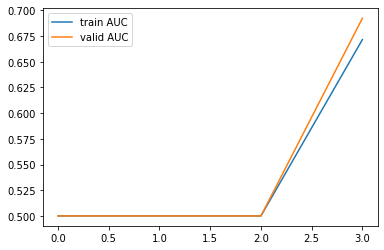

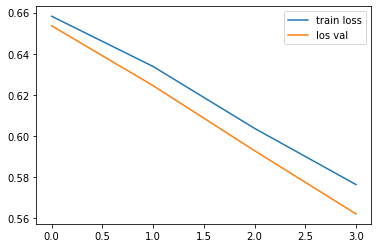

In [30]:
plt.rcParams["figure.figsize"] = (20,6)
plt.plot(AUC_list_train[:], label="train AUC")
plt.plot(AUC_list_test[:], label="valid AUC")
plt.legend()
plt.show() 

plt.plot(los_list_train[:], label="train loss")
plt.plot(los_list_val[:], label="los val")
plt.legend()
plt.show()

In [33]:
#evaluation on the last epoch
auc_val, loss_val = eval_model(downstream_ds_loader)
print("train", auc_val, loss_val)
auc_val, loss_val = eval_model(downstream_ds_loader_val)
print("validation", auc_val, loss_val)


Confusion Matrix of the input set Set
-----------
[[525   0]
 [134  70]]
train 0.6715686274509804 6.897965908050537
Confusion Matrix of the input set Set
-----------
[[116   0]
 [ 24  15]]
validation 0.6923076923076923 0.5619646310806274


In [34]:
#evaluation on best epoch

checkpoint = torch.load('layer_wise_lr_best-model-parameters_hf_1000bs_simp0.pt')
#current_epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict'])

auc_val, loss_val = eval_model(downstream_ds_loader)
print("train", auc_val, loss_val)
auc_val, loss_val = eval_model(downstream_ds_loader_val)
print("validation", auc_val, loss_val)

Confusion Matrix of the input set Set
-----------
[[525   0]
 [134  70]]
train 0.6715686274509804 6.893146991729736
Confusion Matrix of the input set Set
-----------
[[116   0]
 [ 24  15]]
validation 0.6923076923076923 0.5619646906852722
